<a href="https://colab.research.google.com/github/sahug/ds-wandb/blob/main/WANDB%20-%20Session%206%20-%20Hyperparameter%20Sweeps%20in%20PyTorch%20with%20WANDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**WANDB - Session 6 - Hyperparameter Sweeps in PyTorch with WANDB**

**Introduction to Hyperparameter Sweeps using W&B**

Searching through high dimensional hyperparameter spaces to find the most performant model can get unwieldy very fast. Hyperparameter sweeps provide an organized and efficient way to conduct a battle royale of models and pick the most accurate model. They enable this by automatically searching through combinations of hyperparameter values (e.g. learning rate, batch size, number of hidden layers, optimizer type) to find the most optimal values.

In this tutorial we'll see how you can run sophisticated hyperparameter sweeps in 3 easy steps using Weights and Biases.

**Sweeps: An Overview**

Running a hyperparameter sweep with Weights & Biases is very easy. There are just 3 simple steps:

1. **Define the sweep**: we do this by creating a dictionary or a YAML file that specifies the parameters to search through, the search strategy, the optimization metric et all.

2. **Initialize the sweep**: with one line of code we initialize the sweep and pass in the dictionary of sweep configurations: sweep_id = wandb.sweep(sweep_config)

3. **Run the sweep agent**: also accomplished with one line of code, we call wandb.agent() and pass the sweep_id to run, along with a function that defines your model architecture and trains it: wandb.agent(sweep_id, function=train)

And voila! That's all there is to running a hyperparameter sweep! In the notebook below, we'll walk through these 3 steps in more detail.

We highly encourage you to fork this notebook so you can tweak the parameters, try out different models, or try a Sweep with your own dataset!

**Setup**

Start out by installing the experiment tracking library and setting up your free W&B account:

1. Install with !pip install
2. `import` the library into Python
3. `.login()` so you can log metrics to your projects

If you've never used Weights & Biases before, the call to login will give you a link to sign up for an account. W&B is free to use for personal and academic projects!

In [1]:
%%capture
!pip install wandb --upgrade

# workaround to fetch MNIST data
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

**Define the Sweep**

Fundamentally, a Sweep combines a strategy for trying out a bunch of hyperparameter values with the code that evalutes them. Whether that strategy is as simple as trying every option or as complex as BOHB, Weights & Biases Sweeps have you covered. You just need to define your strategy in the form of a configuration.

When you're setting up a Sweep in a notebook like this, that config object is a nested dictionary. When you run a Sweep via the command line, the config object is a YAML file.

Let's walk through the definition of a Sweep config together. We'll do it slowly, so we get a chance to explain each component. In a typical Sweep pipeline, this step would be done in a single assignment.

**Pick a `method`**

The first thing we need to define is the method for choosing new parameter values.

We provide the following search methods:

- **`grid` Search** – Iterate over every combination of hyperparameter values. Very effective, but can be computationally costly.
- **`random` Search** – Select each new combination at random according to provided distributions. Surprisingly effective!
- **`bayesian` Search** – Create a probabilistic model of metric score as a function of the hyperparameters, and choose parameters with high probability of improving the metric. Works well for small numbers of continuous parameters but scales poorly.

We'll stick with random.

In [2]:
sweep_config = {
    'method': 'random'
    }

For `bayesian` Sweeps, you also need to tell us a bit about your metric. We need to know its name, so we can find it in the model outputs and we need to know whether your goal is to minimize it (e.g. if it's the squared error) or to maximize it (e.g. if it's the accuracy).

In [ ]:
metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

If you're not running a bayesian Sweep, you don't have to, but it's not a bad idea to include this in your `sweep_config` anyway, in case you change your mind later. It's also good reproducibility practice to keep note of things like this, in case you, or someone else, come back to your Sweep in 6 months or 6 years and don't know whether `val_G_batch` is supposed to be high or low.

**Name the `hyperparameters`**
Once you've picked a method to try out new values of the hyperparameters, you need to define what those `parameters` are.

Most of the time, this step is straightforward: you just give the `parameter` a name and specify a list of legal values of the parameter.

For example, when we choose the `optimizer` for our network, there's only a finite number of options. Here we stick with the two most popular choices, `adam` and `sgd`. Even for hyperparameters that have potentially infinite options, it usually only makes sense to try out a few select values, as we do here with the hidden `layer_size` and dropout.

In [3]:
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'fc_layer_size': {
        'values': [128, 256, 512]
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict

It's often the case that there are hyperparameters that we don't want to vary in this Sweep, but which we still want to set in our sweep_config.

In that case, we just set the value directly:

In [ ]:
parameters_dict.update({
    'epochs': {
        'value': 1}
    })

For a grid search, that's all you ever need.

For a random search, all the `values` of a parameter are equally likely to be chosen on a given run.

If that just won't do, you can instead specify a named `distribution`, plus its parameters, like the mean `mu` and standard deviation `sigma` of a `normal` distribution.

See more on how to set the distributions of your random variables here.

In [4]:
import math

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms 
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(32),
        'max': math.log(256),
      }
    })

When we're finished, `sweep_config` is a nested dictionary that specifies exactly which `parameters` we're interested in trying and what `method` we're going to use to try them.

In [5]:
import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'parameters': {'batch_size': {'distribution': 'q_log_uniform',
                               'max': 5.545177444479562,
                               'min': 3.4657359027997265,
                               'q': 1},
                'dropout': {'values': [0.3, 0.4, 0.5]},
                'fc_layer_size': {'values': [128, 256, 512]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0},
                'optimizer': {'values': ['adam', 'sgd']}}}


But that's not all of the configuration options!

For example, we also offer the option to `early_terminate` your runs with the [HyperBand](https://arxiv.org/pdf/1603.06560.pdf) scheduling algorithm. See more [here](https://docs.wandb.com/sweeps/configuration#stopping-criteria).

You can find a list of all configuration options [here](https://docs.wandb.com/library/sweeps/configuration)
and a big collection of examples in YAML format [here](https://github.com/wandb/examples/tree/master/examples/keras/keras-cnn-fashion).



**Initialize the Sweep**

Once you've defined the search strategy, it's time to set up something to implement it.

The clockwork taskmaster in charge of our Sweep is known as the _Sweep Controller_.
As each run completes, it will issue a new set of instructions
describing a new run to execute.
These instructions are picked up by _agents_
who actually perform the runs.

In a typical Sweep, the Controller lives on _our_ machine,
while the agents who complete runs live on _your_ machine(s),
like in the diagram below.
This division of labor makes it super easy to scale up Sweeps
by just adding more machines to run agents!

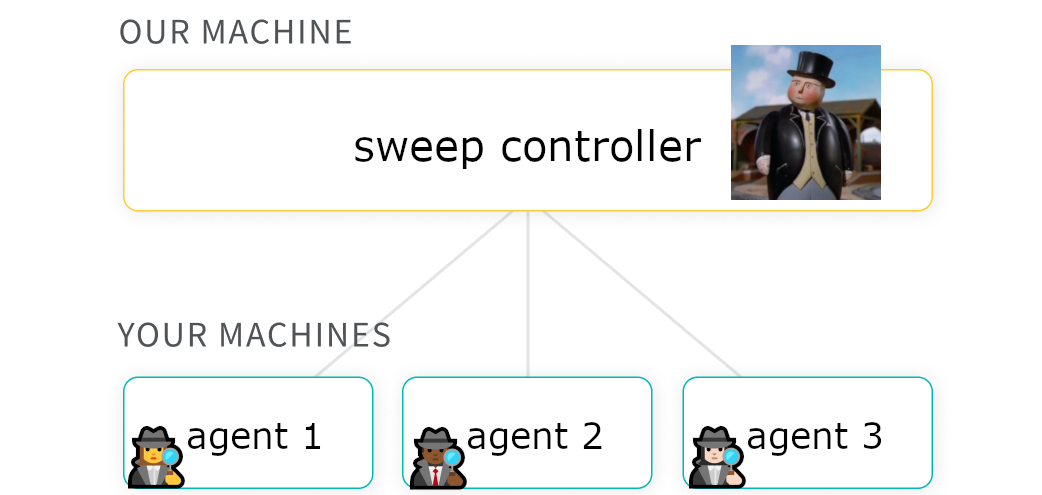

We can wind up a Sweep Controller by calling `wandb.sweep` with the appropriate `sweep_config` and `project` name.

This function returns a `sweep_id` that we will later user to assign agents to this Controller.

> _Side Note_: on the command line, this function is replaced with
```
wandb sweep config.yaml
```

In [7]:
import wandb
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-demo")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: t45bpvn1
Sweep URL: https://wandb.ai/sahug/pytorch-sweeps-demo/sweeps/t45bpvn1


**Run the Sweep agent**

**Define Your Training Procedure**

Before we can actually execute the sweep,
we need to define the training procedure that uses those values.

In the functions below, we define a simple fully-connected neural network in PyTorch, and add the following `wandb` tools to log model metrics, visualize performance and output and track our experiments:
* [**`wandb.init()`**](https://docs.wandb.com/library/init) – Initialize a new W&B Run. Each Run is a single execution of the training function.
* [**`wandb.config`**](https://docs.wandb.com/library/config) – Save all your hyperparameters in a configuration object so they can be logged. Read more about how to use `wandb.config` [here](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-config/Configs_in_W%26B.ipynb).
* [**`wandb.log()`**](https://docs.wandb.com/library/log) – log model behavior to W&B. Here, we just log the performance; see [this Colab](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-log/Log_(Almost)_Anything_with_W%26B_Media.ipynb) for all the other rich media that can be logged with `wandb.log`.

For more details on instrumenting W&B with PyTorch, see [this Colab](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Simple_PyTorch_Integration.ipynb).

In [8]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        loader = build_dataset(config.batch_size)
        network = build_network(config.fc_layer_size, config.dropout)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate)

        for epoch in range(config.epochs):
            avg_loss = train_epoch(network, loader, optimizer)
            wandb.log({"loss": avg_loss, "epoch": epoch})  

This cell defines the four pieces of our training procedure: `build_dataset`, `build_network`, `build_optimizer`, and `train_epoch`.

All of these are a standard part of a basic PyTorch pipeline, and their implementation is unaffected by the use of W&B, so we won't comment on them.

In [ ]:
def build_dataset(batch_size):
   
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))])
    # download MNIST training dataset
    dataset = datasets.MNIST(".", train=True, download=True,
                             transform=transform)
    sub_dataset = torch.utils.data.Subset(
        dataset, indices=range(0, len(dataset), 5))
    loader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size)

    return loader


def build_network(fc_layer_size, dropout):
    network = nn.Sequential(  # fully-connected, single hidden layer
        nn.Flatten(),
        nn.Linear(784, fc_layer_size), nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(fc_layer_size, 10),
        nn.LogSoftmax(dim=1))

    return network.to(device)
        

def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer


def train_epoch(network, loader, optimizer):
    cumu_loss = 0
    for _, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # ➡ Forward pass
        loss = F.nll_loss(network(data), target)
        cumu_loss += loss.item()

        # ⬅ Backward pass + weight update
        loss.backward()
        optimizer.step()

        wandb.log({"batch loss": loss.item()})

    return cumu_loss / len(loader)

Now, we're ready to start sweeping!

Sweep Controllers, like the one we made by running `wandb.sweep`,
sit waiting for someone to ask them for a `config` to try out.

That someone is an `agent`, and they are created with `wandb.agent`.
To get going, the agent just needs to know
1. which Sweep it's a part of (`sweep_id`)
2. which function it's supposed to run (here, `train`)
3. (optionally) how many configs to ask the Controller for (`count`)

FYI, you can start multiple `agent`s with the same `sweep_id`
on different compute resources,
and the Controller will ensure that they work together
according to the strategy laid out in the `sweep_config`.
This makes it trivially easy to scale your Sweeps across as many nodes as you can get ahold of!

> _Side Note:_ on the command line, this function is replaced with
```
wandb agent sweep_id
```

The cell below will launch an `agent` that runs `train` 5 times,
usingly the randomly-generated hyperparameter values returned by the Sweep Controller. Execution takes under 5 minutes.

In [9]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: xl17e2ar with config:
wandb: 	batch_size: 42
wandb: 	dropout: 0.5
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.05258930694141817
wandb: 	optimizer: sgd
wandb: Currently logged in as: sahug (use `wandb login --relogin` to force relogin)


Run xl17e2ar errored: NameError("name 'build_dataset' is not defined")
wandb: ERROR Run xl17e2ar errored: NameError("name 'build_dataset' is not defined")
wandb: Agent Starting Run: ybp5zpad with config:
wandb: 	batch_size: 61
wandb: 	dropout: 0.3
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.012101889565128476
wandb: 	optimizer: adam


Run ybp5zpad errored: NameError("name 'build_dataset' is not defined")
wandb: ERROR Run ybp5zpad errored: NameError("name 'build_dataset' is not defined")
wandb: Agent Starting Run: tbpngtfu with config:
wandb: 	batch_size: 122
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.09402020327147284
wandb: 	optimizer: sgd


Run tbpngtfu errored: NameError("name 'build_dataset' is not defined")
wandb: ERROR Run tbpngtfu errored: NameError("name 'build_dataset' is not defined")
Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: ERROR Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: To disable this check set WANDB_AGENT_DISABLE_FLAPPING=true


**Parallel Coordinates Plot**

This plot maps hyperparameter values to model metrics. It’s useful for honing in on combinations of hyperparameters that led to the best model performance.

**Hyperparameter Importance Plot**

The hyperparameter importance plot surfaces which hyperparameters were the best predictors of your metrics. We report feature importance (from a random forest model) and correlation (implicitly a linear model).